2109106138
Anjasmara

Importing Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
from skimage.io import imread,imshow
from skimage import transform
import os
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense



In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inisialisasi ImageDataGenerator dengan konfigurasi augmentasi yang diinginkan
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Tentukan direktori di mana data latih  disimpan
train_data_dir = 'path_to_train_data_directory'

# Muat data dari direktori dan lakukan augmentasi
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    classes=['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']
)




Found 0 images belonging to 5 classes.


Label Names

In [4]:
labels=list()
path='YogaPoses/'
os.listdir(path)
for i in os.listdir(path):
    labels.append(i)
    

In [5]:
labels

['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']

Preprocessing Images
Resizing
Scaling

In [10]:
img_size=170     # 170x170
X=[] 
Y=[]
i=0
for idx,img in enumerate(os.listdir(path)):
    for img_name in tqdm(os.listdir(path+img)):
        if i<300:
            img_file=imread(path+img+'/'+img_name)
            if img_file is not None:
                img_file=transform.resize(img_file,(img_size,img_size,3))
                X.append(img_file)
                Y.append(idx)
        else:
            break
        i=i+1
    i=0
X=np.asarray(X)
Y=np.asarray(Y)

100%|██████████| 198/198 [00:05<00:00, 38.71it/s]


In [11]:
X[0]   ## Skimage scale image in range of 0 to 1

array([[[0.97647059, 0.97647059, 0.97647059],
        [0.97647059, 0.97647059, 0.97647059],
        [0.97647059, 0.97647059, 0.97647059],
        ...,
        [0.95294118, 0.95294118, 0.95294118],
        [0.95294118, 0.95294118, 0.95294118],
        [0.95294118, 0.95294118, 0.95294118]],

       [[0.97647059, 0.97647059, 0.97647059],
        [0.97647059, 0.97647059, 0.97647059],
        [0.97647059, 0.97647059, 0.97647059],
        ...,
        [0.95294118, 0.95294118, 0.95294118],
        [0.95294118, 0.95294118, 0.95294118],
        [0.95294118, 0.95294118, 0.95294118]],

       [[0.97647059, 0.97647059, 0.97647059],
        [0.97647059, 0.97647059, 0.97647059],
        [0.97647059, 0.97647059, 0.97647059],
        ...,
        [0.95294118, 0.95294118, 0.95294118],
        [0.95294118, 0.95294118, 0.95294118],
        [0.95294118, 0.95294118, 0.95294118]],

       ...,

       [[0.94117647, 0.94117647, 0.94117647],
        [0.94117647, 0.94117647, 0.94117647],
        [0.94117647, 0

Visualizing the Images

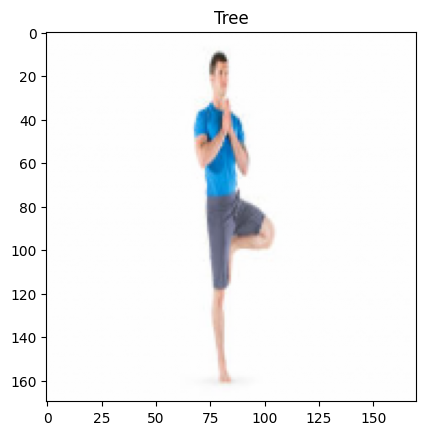

In [12]:
plt.imshow(X[601])
plt.title(labels[Y[601]])
plt.show()

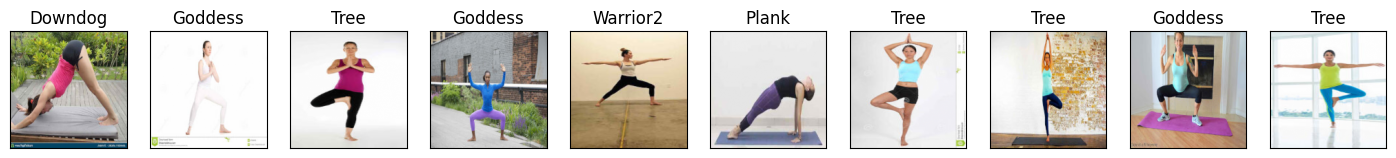

In [13]:
from random import randint
n = 50  # how many digits we will display
plt.figure(figsize=(90,40))
for i in range(10,20):
    # display original
    rn=randint(0,987)
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X[rn])
    plt.title(labels[Y[rn]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.close()

Building the CNN Model

Spliting the Data into the train & test

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y)

In [16]:
from tensorflow.keras.utils import to_categorical

# Mengasumsikan Y_train dan Y_test adalah array label Anda
Y_train = to_categorical(Y_train, num_classes=len(labels))
Y_test = to_categorical(Y_test, num_classes=len(labels))


In [19]:
model=Sequential()
model.add(Conv2D(64,(5,5),padding='same',activation='relu',input_shape=(170,170,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,(4,4),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(50,(3,3),padding='same',activation='relu'))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(len(labels),activation='softmax'))  # Multi-class Classification Problem
model.compile(loss='categorical_crossentropy',optimizer='adam'
             ,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 170, 170, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 21, 21, 128)       0

In [20]:
from time import time
tic=time()
epoch=50
history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epoch,batch_size=32,verbose=1)
toc=time()
print(f'Training Time {toc-tic}')

Epoch 1/50
20/20 [==============================] - 62s 3s/step - loss: 1.5823 - accuracy: 0.2674 - val_loss: 1.2207 - val_accuracy: 0.5443
Epoch 2/50
20/20 [==============================] - 54s 3s/step - loss: 1.1018 - accuracy: 0.5981 - val_loss: 1.1662 - val_accuracy: 0.4684
Epoch 3/50
20/20 [==============================] - 56s 3s/step - loss: 0.8618 - accuracy: 0.6598 - val_loss: 0.7468 - val_accuracy: 0.7089
Epoch 4/50
20/20 [==============================] - 51s 3s/step - loss: 0.6649 - accuracy: 0.7579 - val_loss: 0.6880 - val_accuracy: 0.7532
Epoch 5/50
20/20 [==============================] - 48s 2s/step - loss: 0.5277 - accuracy: 0.8212 - val_loss: 0.7588 - val_accuracy: 0.6962
Epoch 6/50
20/20 [==============================] - 53s 3s/step - loss: 0.3365 - accuracy: 0.8813 - val_loss: 0.5784 - val_accuracy: 0.8165
Epoch 7/50
20/20 [==============================] - 54s 3s/step - loss: 0.1447 - accuracy: 0.9541 - val_loss: 0.6355 - val_accuracy: 0.8165
Epoch 8/50
20/20 [==

## grafik yang menampilkan pergerakan metrik 

Text(0.5, 1.0, 'Loss evolution')

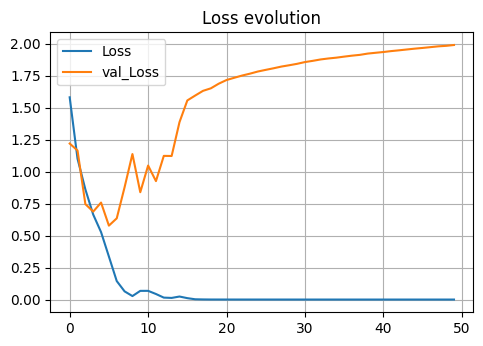

In [21]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy')

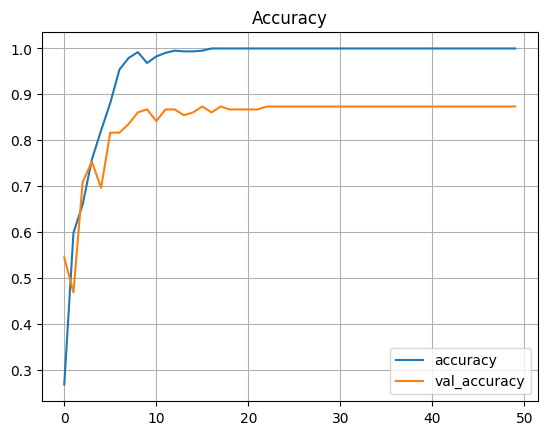

In [22]:
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')